In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Rectangle
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('https://grantmlong.com/data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing Steps

In [3]:
# Dropping usessential features PassengerId, Name, Ticket, and Cabin.
df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

# Imputing NaN and Null data.
imp = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)
df['Age'] = imp.fit_transform(df[['Age']]).ravel()

catimp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Embarked'] = catimp.fit_transform(df[['Embarked']]).ravel()

# Classifying Age and Fare into different buckets/classes.
df['Age'] = df['Age'].apply(lambda x: "Child" if x <= 13 else ("Teenager" if x < 18 else ("Adult" if x < 60 else "Senior Citizen")))

df["Fare"] = df['Fare'].apply(lambda x : "Very Cheap" if x // 25 == 0.0 else ("Cheap" if x // 25 == 1.0 else ("Mid-range" if x // 25 <= 3 else ("Expensive" if x // 25 <= 6 else "Very Expensive"))))

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,Adult,1,0,Very Cheap,S
1,1,1,female,Adult,1,0,Mid-range,C
2,1,3,female,Adult,0,0,Very Cheap,S
3,1,1,female,Adult,1,0,Mid-range,S
4,0,3,male,Adult,0,0,Very Cheap,S


## Implementing Candidate Elimination Algorithm

In [4]:
def g_0(n):
    return ("?",)*n

def s_0(n):
    return ('0',)*n

In [5]:
def more_general(h1, h2):
    more_general_parts = []
    for x, y in zip(h1, h2):
        mg = x == "?" or (x != "0" and (x == y or y == "0"))
        more_general_parts.append(mg)
    return all(more_general_parts)

In [6]:
# min_generalizations
def fulfills(example, hypothesis):
    ### the implementation is the same as for hypotheses:
    return more_general(hypothesis, example)

def min_generalizations(h, x):
    h_new = list(h)
    for i in range(len(h)):
        if not fulfills(x[i:i+1], h[i:i+1]):
            h_new[i] = '?' if h[i] != '0' else x[i]
    return [tuple(h_new)]

In [7]:
def min_specializations(h, domains, x):
    results = []
    for i in range(len(h)):
        if h[i] == "?":
            for val in domains[i]:
                if x[i] != val:
                    h_new = h[:i] + (val,) + h[i+1:]
                    results.append(h_new)
        elif h[i] != "0":
            h_new = h[:i] + ('0',) + h[i+1:]
            results.append(h_new)
    return results

In [8]:
def get_domains(examples):
    d = [set() for i in examples[0]]
    for x in examples:
        for i, xi in enumerate(x):
            d[i].add(xi)
    return [list(sorted(x)) for x in d]

In [9]:
def generalize_S(x, G, S):
    S_prev = list(S)
    for s in S_prev:
        if s not in S:
            continue
        if not fulfills(x, s):
            S.remove(s)
            Splus = min_generalizations(s, x)
            ## keep only generalizations that have a counterpart in G
            S.update([h for h in Splus if any([more_general(g,h) 
                                               for g in G])])
            ## remove hypotheses less specific than any other in S
            S.difference_update([h for h in S if 
                                 any([more_general(h, h1) 
                                      for h1 in S if h != h1])])
    return S

def specialize_G(x, domains, G, S):
    G_prev = list(G)
    for g in G_prev:
        if g not in G:
            continue
        if fulfills(x, g):
            G.remove(g)
            Gminus = min_specializations(g, domains, x)
            ## keep only specializations that have a conuterpart in S
            G.update([h for h in Gminus if any([more_general(h, s)
                                                for s in S])])
            ## remove hypotheses less general than any other in G
            G.difference_update([h for h in G if 
                                 any([more_general(g1, h) 
                                      for g1 in G if h != g1])])
    return G

In [10]:
def candidate_elimination(examples):
    domains = get_domains(examples)[:-1]
    
    G = set([g_0(len(domains))])
    S = set([s_0(len(domains))])
    i=0
    #print("\n G[{0}]:".format(i),G)
    #print("\n S[{0}]:".format(i),S)
    for xcx in examples:
        i=i+1
        x, cx = xcx[:-1], xcx[-1]  # Splitting data into attributes and decisions
        if cx == 1: # x is positive example
            G = {g for g in G if fulfills(x, g)}
            S = generalize_S(x, G, S)
        else: # x is negative example
            S = {s for s in S if not fulfills(x, s)}
            G = specialize_G(x, domains, G, S)
        #print("\n G[{0}]:".format(i),G)
        #print("\n S[{0}]:".format(i),S)
    return G,S

## Running the algorithm on titanic dataset

In [11]:
df = df[["Pclass",	"Sex",	"Age",	"SibSp",	"Parch",	"Fare",	"Embarked", "Survived"]]
data = list(df.itertuples(index=False, name=None))

G, S = candidate_elimination(data[:7])

In [12]:
print("G Boundary:")
for g in G:
  print(g)

print("S Boundary:")
for s in S:
  print(s)

G Boundary:
('?', 'female', '?', '?', '?', '?', '?')
S Boundary:
('?', 'female', 'Adult', '?', 0, '?', '?')


## Plotting/Drawing final hypothesis space

In [13]:
class HypothesisNode(object):
    def __init__(self, h, level=0, parents=None):
        self.h = h
        self.level = level
        if parents is None:
            parents = []
        self.parents = set(parents)
    def __repr__(self):
        return "HypothesisNode({}, {}, {})".format(self.h, self.level, self.parents)

    
def build_hypothesis_space(G, S):
    levels = [[HypothesisNode(x, 0) for x in G]]
    curlevel = 1

    def next_level(h, S):
        for s in S:
            for i in range(len(h)):
                if h[i] == '?' and s[i] != '?':
                    yield h[:i] + (s[i],) + h[i+1:]

    nextLvl = {}
    while True:
        for n in levels[-1]:
            for hyp in next_level(n.h, S):
                if hyp in nextLvl:
                    nextLvl[hyp].parents.add(n)
                else:
                    nextLvl[hyp] = HypothesisNode(hyp, curlevel, [n])
        if not nextLvl:
            break
        levels.append(list(nextLvl.values()))
        curlevel += 1
        nextLvl = {}
    return levels

In [14]:
def draw_hypothesis_space(G, S):
    import networkx as nx
    
    levels = build_hypothesis_space(G, S)

    g = nx.Graph()

    for nodes in levels:
        for n in nodes:
            for p in n.parents:
                g.add_edge(n.h, p.h)

    pos = {}
    ymin = 0.1
    ymax = 0.9

    for nodes, y in [(levels[0], ymin), (levels[-1], ymax)]:
        xvals = np.linspace(0, 1, len(nodes))
        for x, n in zip(xvals, nodes):
            pos[n.h] = [x, y]

    pos = nx.layout.fruchterman_reingold_layout(g, pos=pos, fixed=pos.keys())

    nx.draw_networkx_edges(g, pos=pos, alpha=0.25)
    nx.draw_networkx_labels(g, pos=pos)


    plt.box(True)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1, 2)
    plt.gcf().set_size_inches((20, 10))
    plt.show()

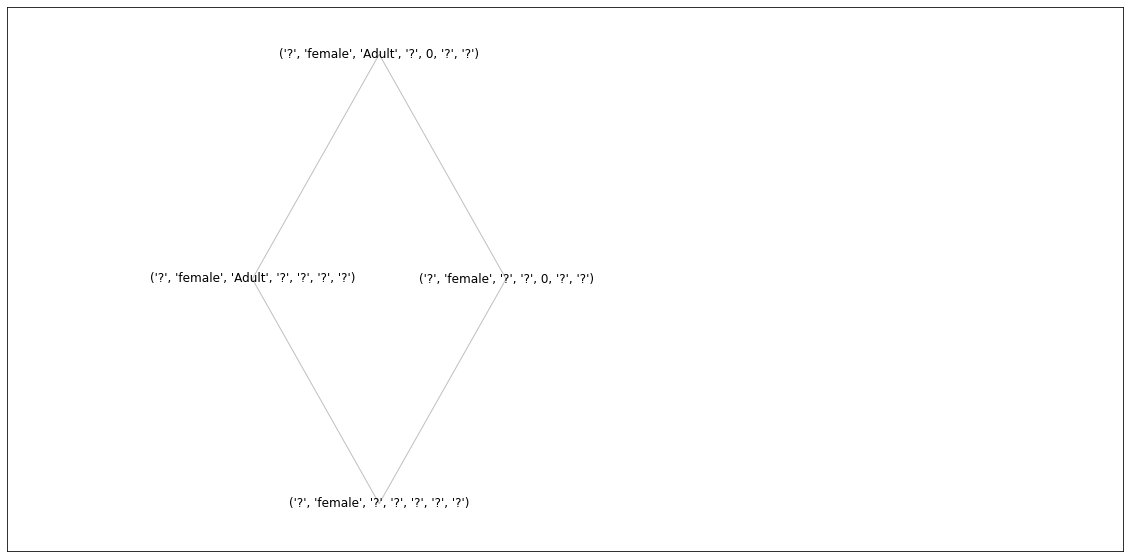

In [15]:
print()
draw_hypothesis_space(G, S)

## Testing the Algorithm

In [16]:
test_data = data[7:]
m, n, d = len(test_data), 0, 7
G, S = G.pop(), S.pop()

for i in range(m):
  flag = True
  for j in range(d):
    if G[j] == '?' or S[j] == '?':
      continue
    elif test_data[i][j] != G[j] or test_data[i][j] != S[j]:
      flag = False
      break
  n += (test_data[i][7] == flag)

print("Accuracy (%)", n / m * 100 )

Accuracy (%) 78.50678733031674
